In [1]:
include("../encoding.jl")
include("../plotting.jl")

heatmapplot (generic function with 1 method)

In [2]:
using Distributions

# One dimension

In [3]:
D = 20_000
x = range(0,1, length=200)

0.0:0.005025125628140704:1.0

In [4]:
n=100
p1, p2, p3, p4 = Distributions.Normal(0.2, 0.05), Distributions.Normal(0.8, 0.05), Distributions.Normal(0.6, 0.1), Distributions.Normal(0.4, 0.07)
xs = vcat(rand(p1, n), rand(p2,n), rand(p3,n), rand(p4,n))
px = (Distributions.pdf.(p1, x).+Distributions.pdf.(p2, x).+Distributions.pdf.(p3, x).+.+Distributions.pdf.(p4, x))/4;
constant = 7/50*n #the constant rescales the y-axis: sample vs functions

14.000000000000002

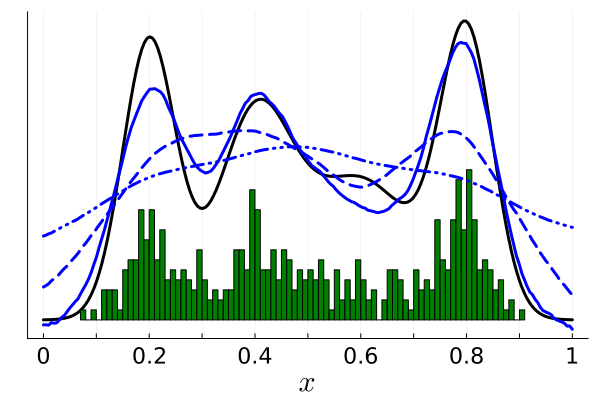

In [5]:
bipolar = true

xvalues = range(0,1,length=11);
xmarks = [0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1]

lengthscales = [0.4, 0.2, 0.1]
linestyles = [:dashdotdot, :dash, :solid]

pl = plot(x, constant*px, color=:black, legend=false, linewidth=3, xticks=(xvalues, xmarks), yticks=nothing, xlabel=L"x")
histogram!(xs, nbins=100, label="", c=:green)
for i in 1:3
    encoder = realvalue_encoder(lengthscales[i],D, bipolar=bipolar);
    Δxs = encode(encoder, xs);
    Δx = encode(encoder, x);
    P = sum(Δxs',dims=2) / length(xs);
    plot!(x, constant*Δx * P / D, linewidth=3, c=:blue, linestyle=linestyles[i])
end
plot!(guidefontsize=20, tickfontsize=15,left_margin = 5Plots.mm)

save(pl, "1D_bipolar"*string(bipolar))

pl

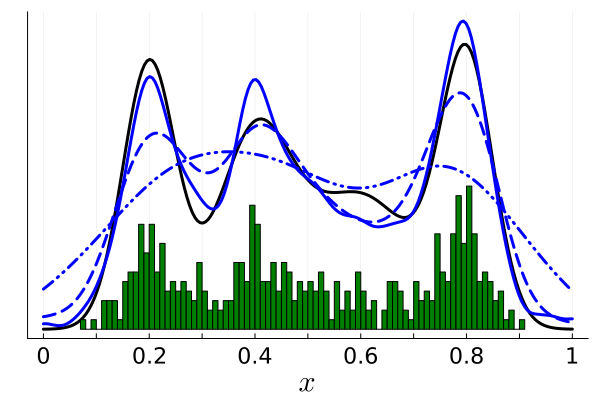

In [6]:
bipolar = false

xvalues = range(0,1,length=11);
xmarks = [0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1]

lengthscales = [0.4, 0.2, 0.1]
linestyles = [:dashdotdot, :dash, :solid]

pl = plot(x, constant*px, color=:black, legend=false, linewidth=3, xticks=(xvalues, xmarks), yticks=nothing, xlabel=L"x")
histogram!(xs, nbins=100, label="", c=:green)
for i in 1:3
    encoder = realvalue_encoder(lengthscales[i],D, bipolar=bipolar);
    Δxs = encode(encoder, xs);
    Δx = encode(encoder, x);
    P = sum(Δxs',dims=2) / length(xs);
    plot!(x, constant*Δx * P / D, linewidth=3, c=:blue, linestyle=linestyles[i])
end
plot!(guidefontsize=20, tickfontsize=15,left_margin = 5Plots.mm)

save(pl, "1D_bipolar"*string(bipolar))

pl

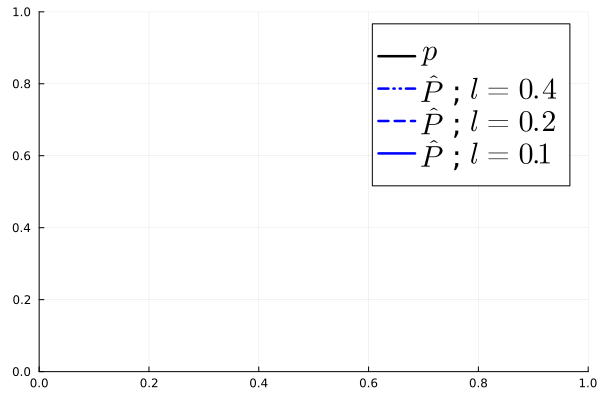

In [7]:
# generate the guide for previous figures
guide = plot([2],[2],xlim=(0,1), ylim=(0,1), legendfontsize=20, c=:black, label=L"p")
for i in 1:3
    plot!([2,2], [2,2],linewidth=3, c=:blue, linestyle=linestyles[i], label=L"$\hat{P}$ ; $l="*string(lengthscales[i]))
end
    
save(guide, "1D_guide")
guide

# Two Dimensions

In [8]:
using Base.Iterators
using LinearAlgebra

In [9]:
D, l = 20_000, 0.1
x = range(0,1, length=100)
xy_grid = collect(product(x,x));
xy = collect(reduce(hcat, collect.(vec(xy_grid)))');

In [10]:
function f(args::Vector)
    m1 = [0.35,0.35]
    m2 = [0.65,0.65]
    s = 0.15
    return exp(-LinearAlgebra.norm(((args .-m1) /s))^2) + exp(-LinearAlgebra.norm(((args .-m2) /s))^2)
end
fxy = reshape(f.(xy[i,:] for i in 1:size(xy, 1)), size(xy_grid));
pxy = fxy ./mean(fxy);

In [11]:
xmarks = [0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1]
xvalues=range(1,size(fxy,1), length=length(xmarks))

1.0:9.9:100.0

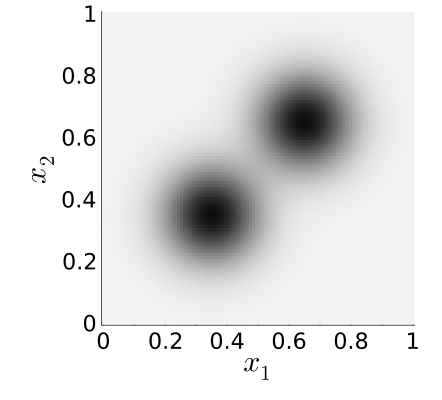

In [12]:
pl = heatmapplot(fxy, cgrad(:grays, rev=true), colorbar=false)
save(pl, "2D_distribution")
pl

In [13]:
bipolar = true

encoder = realvalue_encoder(l,D, bipolar=bipolar);
Δxy = encode(encoder, xy[:,1]) .* circshift(encode(encoder, xy[:,2]), (0,1));

In [14]:
xys = rand(10000,2)
fxys = [f(xys[i,:]) for i in 1:size(xys,1)]
pxys = fxys / maximum(fxys)
xys = xys[(pxys .> rand(10000)),:][1:100,:];

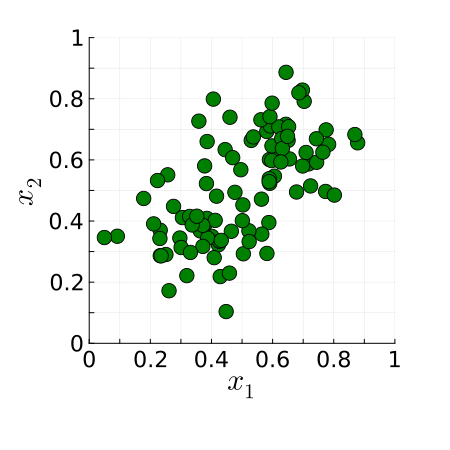

In [15]:
xvalues = range(0,1,length=11)
pl = scatterplot(xys[:,1], xys[:,2],nothing,:green,1, xlabel=L"x_1", ylabel=L"x_2")

save(pl, "2D_sample")
pl

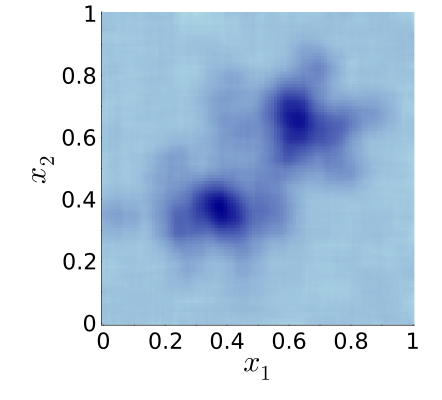

In [16]:
xvalues = range(1,100,length=11)
Δxys = encode(encoder, xys[:,1]) .* circshift(encode(encoder, xys[:,2]), (0,1))
P = sum(Δxys',dims=2) / size(xys,1);

pl = heatmapplot(reshape(Δxy * P / D, size(fxy))', cgrad(:blues, rev=false), colorbar=false, clim=nothing)
save(pl, "2D_bipolar"*string(bipolar))
pl

# Proteins

In [17]:
using DelimitedFiles

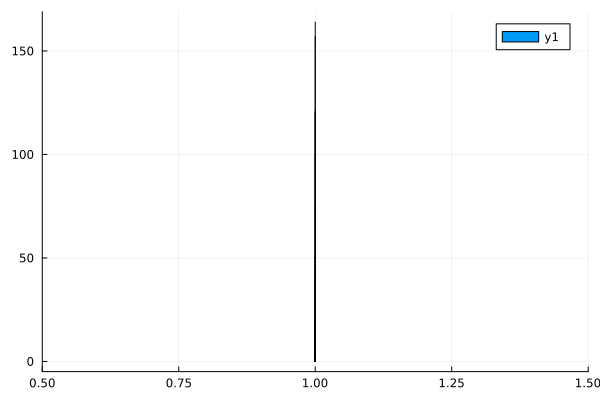

In [18]:
ϕx = readdlm("../proteins_X") .+ 0.04  #a small value is added to account for negative values when computing normalizatin function
y = readdlm("../proteins_y")[:]
umapx = readdlm("../proteins_UMAP");
bounds = 0.1
umapx = (1-2*bounds)*umapx .+bounds # some space at the boundaries for a nicer plot

D = size(ϕx,2)
K = ϕx*ϕx' / D
n = find_normalization(K, n_iter=10)
Δx = ϕx ./ n;

histogram(mean(Δx*Δx'/D, dims=2),xlim=(0.5,1.5))

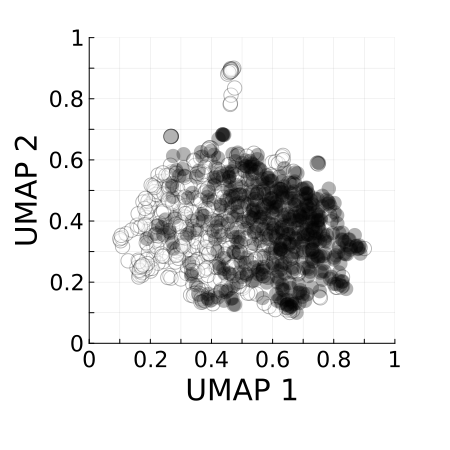

In [19]:
order = sortperm(-y)
pl = scatterplot(umapx[order,1], umapx[order,2], y[order], cgrad(:greys, rev=false), 0.3, colorbar=false)
save(pl, "protein_density")
    
pl

In [20]:
neg = collect(1:length(y))[y.==-1]
sample =  neg[400:end];
length(sample)

101

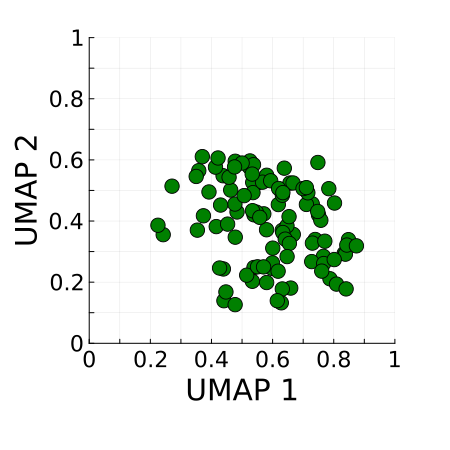

In [21]:
pl = scatterplot(umapx[sample,1], umapx[sample,2], nothing, :green, 1, colorbar=false)
save(pl, "protein_sample")
pl

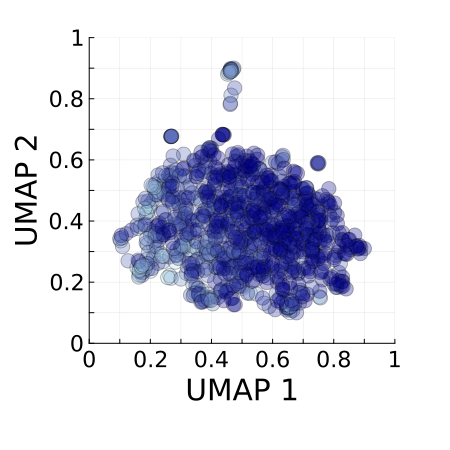

In [22]:
order = sortperm(-y)
P = (sum(Δx[sample,:], dims=1) /length(sample))[:]
pl = scatterplot(umapx[order,1], umapx[order,2], (Δx *P / D)[order], cgrad(:blues, rev=false), 0.3, colorbar=false)
save(pl, "protein_bipolartrue")
pl